/home/msp/crematory/venv/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


✅ 결과 저장 완료: model_results_with_purged_cv.csv

=== 전체 결과 ===
          Model         MAE        RMSE      sMAPE        R²  \
0        Linear   25.693653   32.945003   1.331495  0.983210   
1         Ridge   24.764345   32.431428   1.266870  0.983729   
2  RandomForest   90.367660  162.052854   4.467420  0.593755   
3       XGBoost   66.325748  137.955093   3.175183  0.705592   
4        Linear   32.650216   41.804068   2.241088  0.889886   
5         Ridge   23.481857   30.302824   1.420560  0.938158   
6  RandomForest  202.236420  238.008637  14.356343 -2.799133   
7       XGBoost  175.259050  209.007293  12.103833 -1.821558   

                  Type  
0              Holdout  
1              Holdout  
2              Holdout  
3              Holdout  
4  CV (5-fold, purged)  
5  CV (5-fold, purged)  
6  CV (5-fold, purged)  
7  CV (5-fold, purged)  

=== 모델별 평가지표 (Holdout vs CV) ===
                             MAE                           RMSE              \
Type         CV (5-fold, 

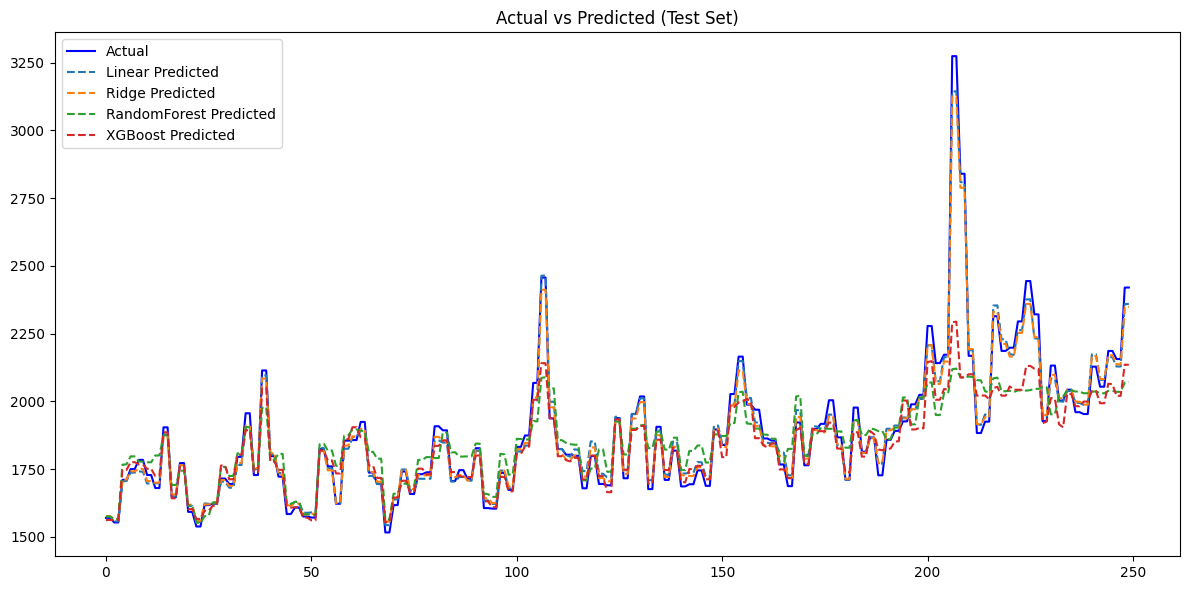

✅ 예측 그래프 저장 완료: model_predictions.png
✅ RF 변수 중요도 저장 완료: rf_feature_importances.csv


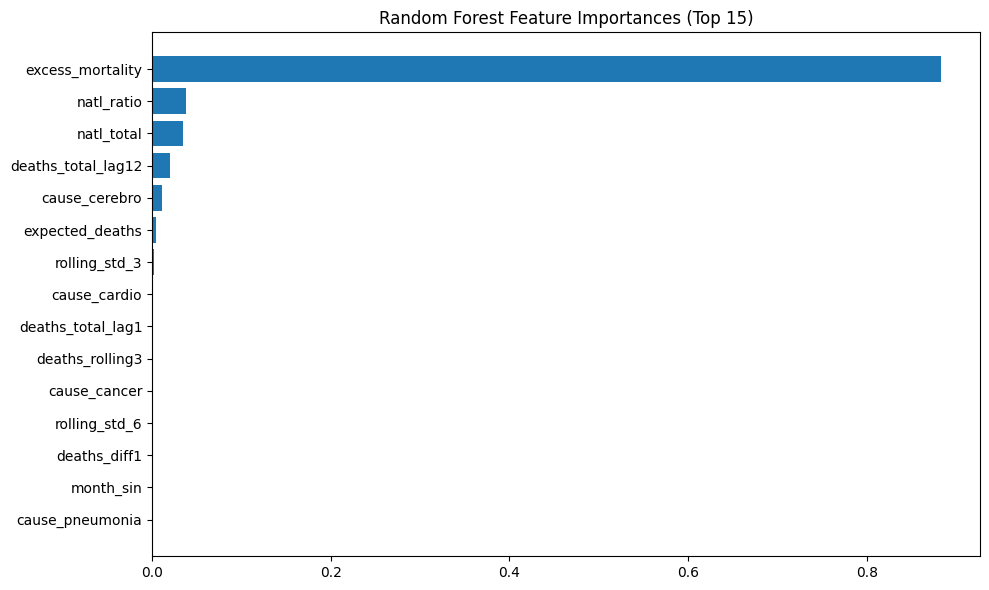

✅ RF 변수 중요도 그래프 저장 완료: rf_feature_importances.png
✅ XGBoost 변수 중요도 저장 완료: xgb_feature_importances.csv


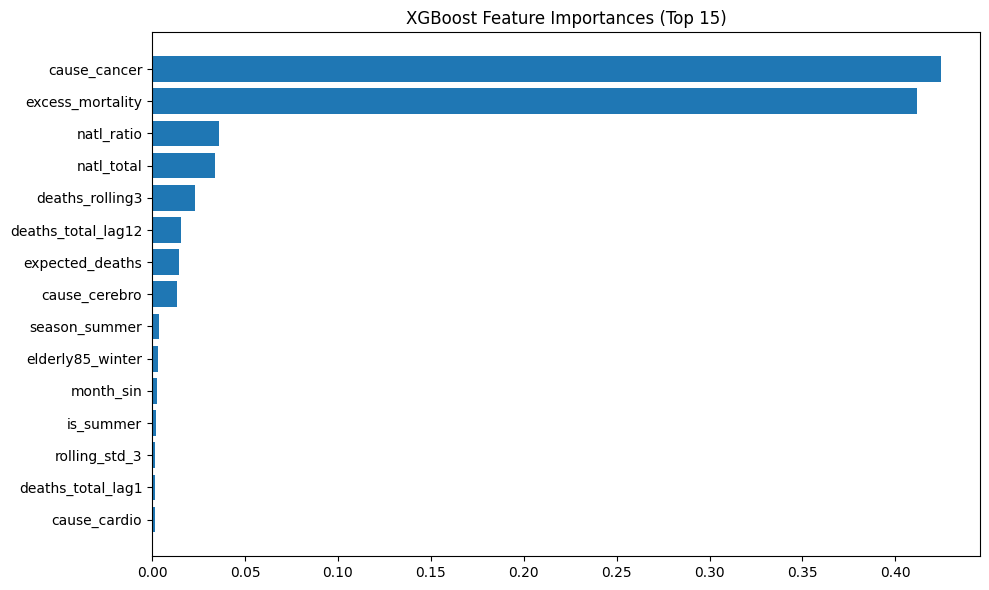

✅ XGBoost 변수 중요도 그래프 저장 완료: xgb_feature_importances.png


In [1]:
# ==============================
# 0. 환경 설정
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer

# ==============================
# 1. 데이터 불러오기 (v5)
# ==============================
df = pd.read_csv("../data/daegu_gyeongbuk_training_dataset_v6.csv")

drop_cols = ["date", "region"]
X = df.drop(columns=["deaths_total"] + drop_cols)
y = df["deaths_total"].fillna(df["deaths_total"].median())

# ==============================
# 2. 학습/테스트 분리 + 결측치 처리
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# ==============================
# 3. 모델 정의
# ==============================
models = {
    "Linear": LinearRegression(),
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 20), cv=5),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42
    )
}

# ==============================
# 4. 평가 함수
# ==============================
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    smape = 100/len(y_test) * np.sum(
        2 * np.abs(preds - y_test) / (np.abs(y_test) + np.abs(preds))
    )
    r2 = r2_score(y_test, preds)
    return mae, rmse, smape, r2, preds

# ==============================
# 5. 홀드아웃 평가
# ==============================
results = []
pred_dict = {}
for name, model in models.items():
    mae, rmse, smape, r2, preds = evaluate_model(
        model, X_train, y_train, X_test, y_test
    )
    results.append({
        "Model": name, "MAE": mae, "RMSE": rmse,
        "sMAPE": smape, "R²": r2, "Type": "Holdout"
    })
    pred_dict[name] = preds

# ==============================
# 6. Purged CV 구현
# ==============================
def purged_cv(X, y, n_splits=5, purge=1):
    fold_size = len(X) // n_splits
    for i in range(n_splits):
        start = 0
        end = fold_size * (i+1)
        train_end = end - fold_size
        val_start = train_end + purge
        if val_start >= end:
            continue
        train_idx = np.arange(start, train_end)
        val_idx = np.arange(val_start, end)
        yield train_idx, val_idx

# ==============================
# 7. 교차검증 (Purged CV)
# ==============================
for name, model in models.items():
    mae_scores, rmse_scores, smape_scores, r2_scores = [], [], [], []
    for train_idx, val_idx in purged_cv(X_train, y_train, n_splits=5, purge=1):
        if len(train_idx) == 0 or len(val_idx) == 0:
            continue
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        mae_scores.append(mean_absolute_error(y_val, preds))
        rmse_scores.append(mean_squared_error(y_val, preds, squared=False))
        smape_scores.append(
            100/len(y_val) * np.sum(2 * np.abs(preds - y_val) / (np.abs(y_val) + np.abs(preds)))
        )
        r2_scores.append(r2_score(y_val, preds))
    if mae_scores:
        results.append({
            "Model": name,
            "MAE": np.mean(mae_scores),
            "RMSE": np.mean(rmse_scores),
            "sMAPE": np.mean(smape_scores),
            "R²": np.mean(r2_scores),
            "Type": "CV (5-fold, purged)"
        })

# ==============================
# 8. 결과 저장 & 출력
# ==============================
results_df = pd.DataFrame(results)
results_df.to_csv("model_results_with_purged_cv.csv", index=False)
print("✅ 결과 저장 완료: model_results_with_purged_cv.csv")

print("\n=== 전체 결과 ===")
print(results_df)

print("\n=== 모델별 평가지표 (Holdout vs CV) ===")
print(results_df.pivot(index="Model", columns="Type", values=["MAE","RMSE","sMAPE","R²"]))

# ==============================
# 9. 예측 결과 시각화 & 저장
# ==============================
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", color="blue")
for name, preds in pred_dict.items():
    plt.plot(preds, linestyle="--", label=f"{name} Predicted")
plt.title("Actual vs Predicted (Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig("model_predictions.png")
plt.show()
print("✅ 예측 그래프 저장 완료: model_predictions.png")

# ==============================
# 10. RandomForest Feature Importance
# ==============================
rf_model = models["RandomForest"]
rf_model.fit(X_train, y_train)

feat_names = df.drop(columns=["deaths_total", "date", "region"]).columns
rf_importances = rf_model.feature_importances_

rf_importance_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": rf_importances
}).sort_values(by="Importance", ascending=False)

rf_importance_df.to_csv("rf_feature_importances.csv", index=False)
print("✅ RF 변수 중요도 저장 완료: rf_feature_importances.csv")

plt.figure(figsize=(10,6))
plt.barh(rf_importance_df["Feature"][:15], rf_importance_df["Importance"][:15])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances (Top 15)")
plt.tight_layout()
plt.savefig("rf_feature_importances.png")
plt.show()
print("✅ RF 변수 중요도 그래프 저장 완료: rf_feature_importances.png")

# ==============================
# 11. XGBoost Feature Importance
# ==============================
xgb_model = models["XGBoost"]
xgb_model.fit(X_train, y_train)

xgb_importances = xgb_model.feature_importances_  # 기본 = gain 기준
xgb_importance_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": xgb_importances
}).sort_values(by="Importance", ascending=False)

xgb_importance_df.to_csv("xgb_feature_importances.csv", index=False)
print("✅ XGBoost 변수 중요도 저장 완료: xgb_feature_importances.csv")

plt.figure(figsize=(10,6))
plt.barh(xgb_importance_df["Feature"][:15], xgb_importance_df["Importance"][:15])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances (Top 15)")
plt.tight_layout()
plt.savefig("xgb_feature_importances.png")
plt.show()
print("✅ XGBoost 변수 중요도 그래프 저장 완료: xgb_feature_importances.png")


✅ 결과 저장 완료: final_model_results.csv
     Model    Val_MAE   Val_RMSE    Val_R²   Test_MAE   Test_RMSE   Test_R²
0    Ridge  29.911690  36.754310  0.889988  39.112868   51.393589  0.959141
1  XGBoost  37.281006  46.809611  0.821560  84.504906  144.039532  0.679050


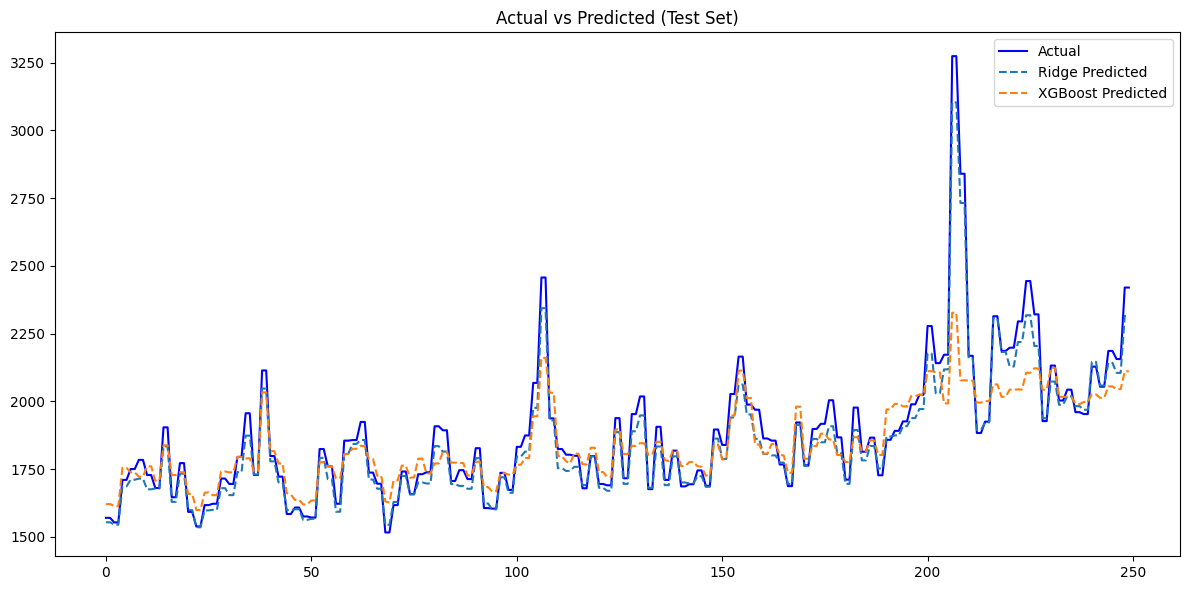

✅ 예측 그래프 저장 완료: final_model_predictions.png
✅ 모델 저장 완료 (Ridge_model.pkl, XGBoost_model.pkl)


In [5]:
# ==============================
# 0. 환경 설정
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
import joblib

# ==============================
# 1. 데이터 불러오기 (v6)
# ==============================
df = pd.read_csv("../data/daegu_gyeongbuk_training_dataset_v6.csv")

drop_cols = ["date", "region"]
X = df.drop(columns=["deaths_total"] + drop_cols)
y = df["deaths_total"].fillna(df["deaths_total"].median())

# ==============================
# 2. 학습/검증/테스트 분리 + 결측치 처리
# ==============================
# 먼저 train/test 분리
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
# train/valid 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, shuffle=False
)

# 결측치 처리 (median)
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# ==============================
# 3. 모델 정의 (Ridge, XGBoost만)
# ==============================
models = {
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 20), cv=5),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42
    )
}

# ==============================
# 4. 평가 함수
# ==============================
def evaluate_model(model, X_tr, y_tr, X_val, y_val, X_te, y_te):
    model.fit(X_tr, y_tr)
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_te)

    metrics = {
        "Val_MAE": mean_absolute_error(y_val, val_preds),
        "Val_RMSE": np.sqrt(mean_squared_error(y_val, val_preds)),
        "Val_R²": r2_score(y_val, val_preds),
        "Test_MAE": mean_absolute_error(y_te, test_preds),
        "Test_RMSE": np.sqrt(mean_squared_error(y_te, test_preds)),
        "Test_R²": r2_score(y_te, test_preds)
    }
    return metrics, val_preds, test_preds


# ==============================
# 5. 학습 & 검증 & 테스트 평가
# ==============================
results = []
pred_dict = {}
for name, model in models.items():
    metrics, val_preds, test_preds = evaluate_model(
        model, X_train, y_train, X_val, y_val, X_test, y_test
    )
    results.append({"Model": name, **metrics})
    pred_dict[name] = test_preds

results_df = pd.DataFrame(results)
results_df.to_csv("final_model_results.csv", index=False)
print("✅ 결과 저장 완료: final_model_results.csv")
print(results_df)

# ==============================
# 6. 예측 결과 시각화
# ==============================
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", color="blue")
for name, preds in pred_dict.items():
    plt.plot(preds, linestyle="--", label=f"{name} Predicted")
plt.title("Actual vs Predicted (Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig("final_model_predictions.png")
plt.show()
print("✅ 예측 그래프 저장 완료: final_model_predictions.png")

# ==============================
# 7. 모델 저장
# ==============================
for name, model in models.items():
    joblib.dump(model, f"{name}_model.pkl")
print("✅ 모델 저장 완료 (Ridge_model.pkl, XGBoost_model.pkl)")

# ==============================
# 8. 향후 수요 예측 예시
# ==============================
# (X_future: 향후 데이터셋 만들어 넣으면 동일하게 사용)
# X_future = ... (추가 입력)
# X_future = imputer.transform(X_future)
# preds_future = models["XGBoost"].predict(X_future)
# print("향후 화장 수요 예측:", preds_future[:10])


✅ 결과 저장 완료: results_dropna.csv
     Model    Val_MAE   Val_RMSE    Val_R²   Test_MAE   Test_RMSE   Test_R²
0    Ridge  21.930338  28.008943  0.939970  31.195136   41.086656  0.974629
1  XGBoost  38.282120  49.822186  0.810057  90.701973  149.549617  0.663871


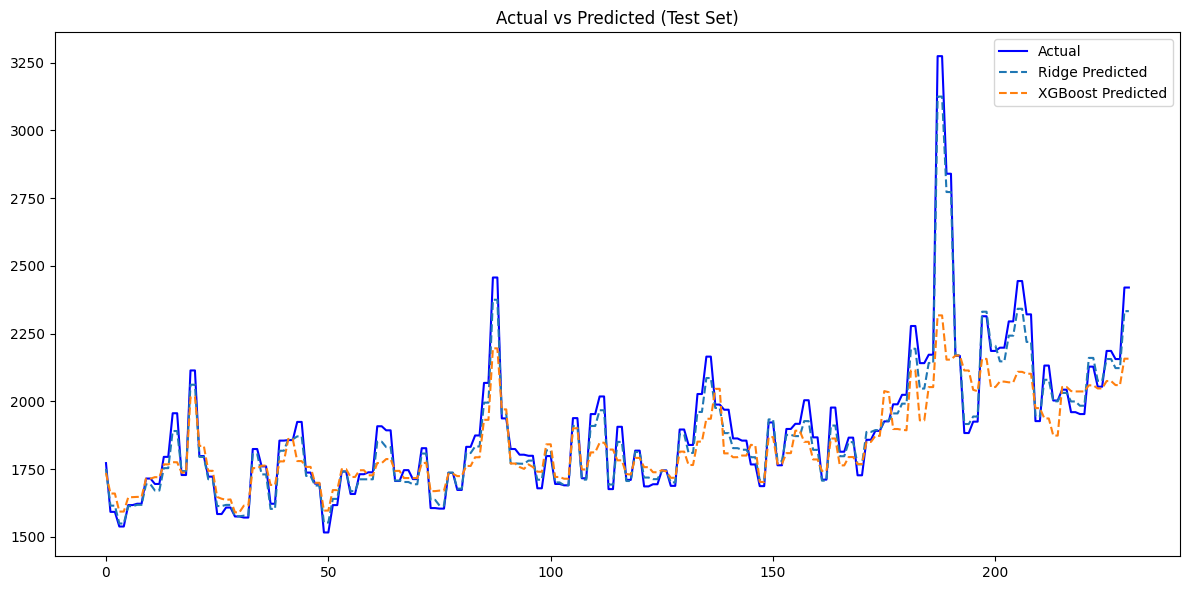

✅ 예측 그래프 저장 완료: predictions_dropna.png
✅ 모델 저장 완료 (Ridge_dropna.pkl, XGBoost_dropna.pkl)


In [6]:
# ==============================
# 0. 환경 설정
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
import joblib

# ==============================
# 1. 데이터 불러오기 (v6)
# ==============================
df = pd.read_csv("../data/daegu_gyeongbuk_training_dataset_v6.csv")

drop_cols = ["date", "region"]
X = df.drop(columns=["deaths_total"] + drop_cols)
y = df["deaths_total"]

# 🔹 결측치 있는 행 삭제
data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns=["deaths_total"])
y = data["deaths_total"]

# ==============================
# 2. 학습/검증/테스트 분리
# ==============================
# 먼저 train/test 분리
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
# train/valid 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, shuffle=False
)

# ==============================
# 3. 모델 정의 (Ridge, XGBoost만)
# ==============================
models = {
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 20), cv=5),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42
    )
}

# ==============================
# 4. 평가 함수
# ==============================
def evaluate_model(model, X_tr, y_tr, X_val, y_val, X_te, y_te):
    model.fit(X_tr, y_tr)
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_te)

    metrics = {
        "Val_MAE": mean_absolute_error(y_val, val_preds),
        "Val_RMSE": np.sqrt(mean_squared_error(y_val, val_preds)),
        "Val_R²": r2_score(y_val, val_preds),
        "Test_MAE": mean_absolute_error(y_te, test_preds),
        "Test_RMSE": np.sqrt(mean_squared_error(y_te, test_preds)),
        "Test_R²": r2_score(y_te, test_preds)
    }
    return metrics, val_preds, test_preds


# ==============================
# 5. 학습 & 검증 & 테스트 평가
# ==============================
results = []
pred_dict = {}
for name, model in models.items():
    metrics, val_preds, test_preds = evaluate_model(
        model, X_train, y_train, X_val, y_val, X_test, y_test
    )
    results.append({"Model": name, **metrics})
    pred_dict[name] = test_preds

results_df = pd.DataFrame(results)
results_df.to_csv("results_dropna.csv", index=False)   # 🔹 파일명 변경
print("✅ 결과 저장 완료: results_dropna.csv")
print(results_df)

# ==============================
# 6. 예측 결과 시각화
# ==============================
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", color="blue")
for name, preds in pred_dict.items():
    plt.plot(preds, linestyle="--", label=f"{name} Predicted")
plt.title("Actual vs Predicted (Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig("predictions_dropna.png")   # 🔹 파일명 변경
plt.show()
print("✅ 예측 그래프 저장 완료: predictions_dropna.png")

# ==============================
# 7. 모델 저장
# ==============================
for name, model in models.items():
    joblib.dump(model, f"{name}_dropna.pkl")   # 🔹 파일명 변경
print("✅ 모델 저장 완료 (Ridge_dropna.pkl, XGBoost_dropna.pkl)")

# ==============================
# 8. 향후 수요 예측 예시
# ==============================
# (X_future: 향후 데이터셋 만들어 넣으면 동일하게 사용)
# X_future = ... (추가 입력)
# preds_future = models["XGBoost"].predict(X_future.dropna())
# print("향후 화장 수요 예측:", preds_future[:10])


✅ 결과 저장 완료: results_dropna.csv
     Model    Val_MAE   Val_RMSE    Val_R²   Test_MAE   Test_RMSE   Test_R²
0    Ridge  21.930338  28.008943  0.939970  31.195136   41.086656  0.974629
1  XGBoost  38.282120  49.822186  0.810057  90.701973  149.549617  0.663871


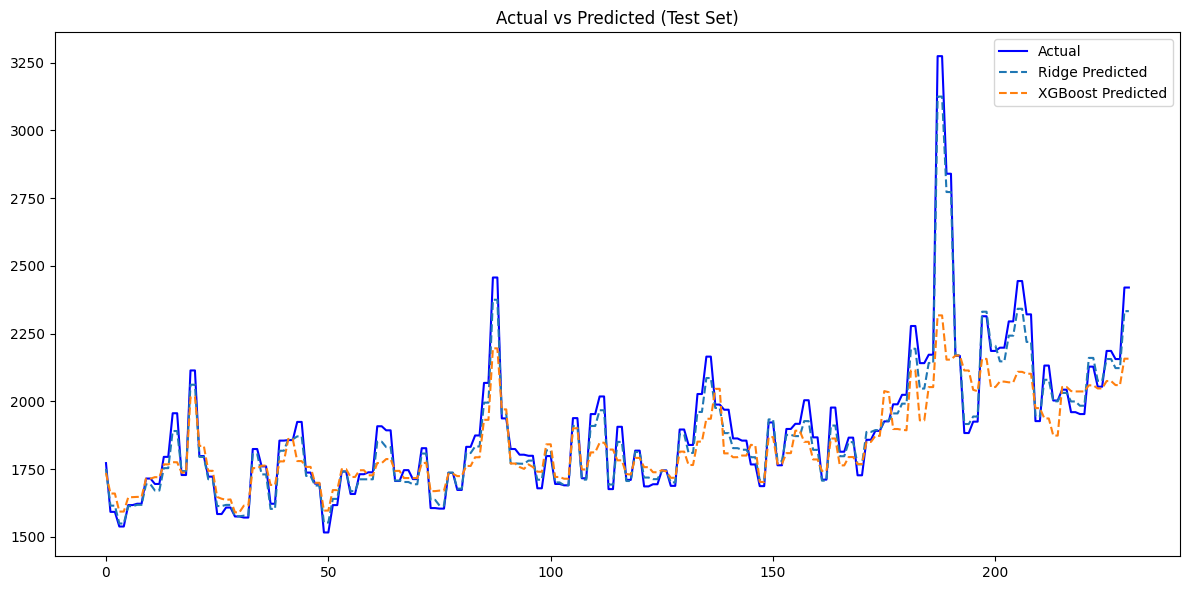

✅ 예측 그래프 저장 완료: predictions_dropna.png
✅ 모델 저장 완료 (Ridge_dropna.pkl, XGBoost_dropna.pkl)


In [9]:
# ==============================
# 0. 환경 설정
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
import joblib

# ==============================
# 1. 데이터 불러오기 (v6)
# ==============================
df = pd.read_csv("../data/daegu_gyeongbuk_training_dataset_v6.csv")

drop_cols = ["date", "region"]
X = df.drop(columns=["deaths_total"] + drop_cols)
y = df["deaths_total"]

# 🔹 결측치 있는 행 삭제
data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns=["deaths_total"])
y = data["deaths_total"]

# ==============================
# 2. 학습/검증/테스트 분리
# ==============================
# 먼저 train/test 분리
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
# train/valid 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, shuffle=False
)

# ==============================
# 3. 모델 정의 (Ridge, XGBoost만)
# ==============================
models = {
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 20), cv=5),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42
    )
}

# ==============================
# 4. 평가 함수
# ==============================
def evaluate_model(model, X_tr, y_tr, X_val, y_val, X_te, y_te):
    model.fit(X_tr, y_tr)
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_te)

    metrics = {
        "Val_MAE": mean_absolute_error(y_val, val_preds),
        "Val_RMSE": np.sqrt(mean_squared_error(y_val, val_preds)),
        "Val_R²": r2_score(y_val, val_preds),
        "Test_MAE": mean_absolute_error(y_te, test_preds),
        "Test_RMSE": np.sqrt(mean_squared_error(y_te, test_preds)),
        "Test_R²": r2_score(y_te, test_preds)
    }
    return metrics, val_preds, test_preds


# ==============================
# 5. 학습 & 검증 & 테스트 평가
# ==============================
results = []
pred_dict = {}
for name, model in models.items():
    metrics, val_preds, test_preds = evaluate_model(
        model, X_train, y_train, X_val, y_val, X_test, y_test
    )
    results.append({"Model": name, **metrics})
    pred_dict[name] = test_preds

results_df = pd.DataFrame(results)
results_df.to_csv("results_dropna.csv", index=False)   # 🔹 파일명 변경
print("✅ 결과 저장 완료: results_dropna.csv")
print(results_df)

# ==============================
# 6. 예측 결과 시각화
# ==============================
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", color="blue")
for name, preds in pred_dict.items():
    plt.plot(preds, linestyle="--", label=f"{name} Predicted")
plt.title("Actual vs Predicted (Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig("predictions_dropna.png")   # 🔹 파일명 변경
plt.show()
print("✅ 예측 그래프 저장 완료: predictions_dropna.png")

# ==============================
# 7. 모델 저장
# ==============================
for name, model in models.items():
    joblib.dump(model, f"{name}_dropna.pkl")   # 🔹 파일명 변경
print("✅ 모델 저장 완료 (Ridge_dropna.pkl, XGBoost_dropna.pkl)")

# ==============================
# 8. 향후 수요 예측 예시
# ==============================
# (X_future: 향후 데이터셋 만들어 넣으면 동일하게 사용)
# X_future = ... (추가 입력)
# preds_future = models["XGBoost"].predict(X_future.dropna())
# print("향후 화장 수요 예측:", preds_future[:10])


✅ 결과 저장 완료: final_model_results.csv
     Model    Val_MAE   Val_RMSE    Val_R²   Test_MAE   Test_RMSE   Test_R²
0    Ridge  29.911690  36.754310  0.889988  39.112868   51.393589  0.959141
1  XGBoost  37.281006  46.809611  0.821560  84.504906  144.039532  0.679050


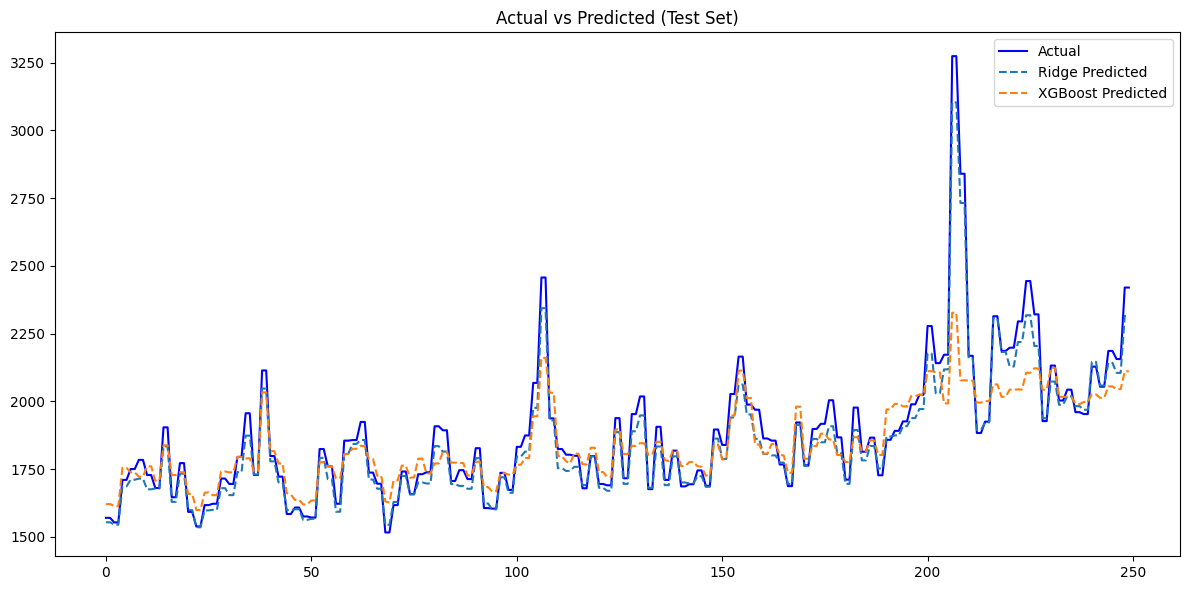

✅ 예측 그래프 저장 완료: final_model_predictions.png
✅ 모델 저장 완료 (Ridge_model.pkl, XGBoost_model.pkl)


In [8]:
# ==============================
# 0. 환경 설정
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
import joblib

# ==============================
# 1. 데이터 불러오기 (v6)
# ==============================
df = pd.read_csv("../data/daegu_gyeongbuk_training_dataset_v6.csv")

drop_cols = ["date", "region"]
X = df.drop(columns=["deaths_total"] + drop_cols)
y = df["deaths_total"].fillna(df["deaths_total"].median())

# ==============================
# 2. 학습/검증/테스트 분리 + 결측치 처리
# ==============================
# 먼저 train/test 분리
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
# train/valid 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, shuffle=False
)

# 결측치 처리 (median)
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# ==============================
# 3. 모델 정의 (Ridge, XGBoost만)
# ==============================
models = {
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 20), cv=5),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42
    )
}

# ==============================
# 4. 평가 함수
# ==============================
def evaluate_model(model, X_tr, y_tr, X_val, y_val, X_te, y_te):
    model.fit(X_tr, y_tr)
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_te)

    metrics = {
        "Val_MAE": mean_absolute_error(y_val, val_preds),
        "Val_RMSE": np.sqrt(mean_squared_error(y_val, val_preds)),
        "Val_R²": r2_score(y_val, val_preds),
        "Test_MAE": mean_absolute_error(y_te, test_preds),
        "Test_RMSE": np.sqrt(mean_squared_error(y_te, test_preds)),
        "Test_R²": r2_score(y_te, test_preds)
    }
    return metrics, val_preds, test_preds


# ==============================
# 5. 학습 & 검증 & 테스트 평가
# ==============================
results = []
pred_dict = {}
for name, model in models.items():
    metrics, val_preds, test_preds = evaluate_model(
        model, X_train, y_train, X_val, y_val, X_test, y_test
    )
    results.append({"Model": name, **metrics})
    pred_dict[name] = test_preds

results_df = pd.DataFrame(results)
results_df.to_csv("final_model_results.csv", index=False)
print("✅ 결과 저장 완료: final_model_results.csv")
print(results_df)

# ==============================
# 6. 예측 결과 시각화
# ==============================
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", color="blue")
for name, preds in pred_dict.items():
    plt.plot(preds, linestyle="--", label=f"{name} Predicted")
plt.title("Actual vs Predicted (Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig("final_model_predictions.png")
plt.show()
print("✅ 예측 그래프 저장 완료: final_model_predictions.png")

# ==============================
# 7. 모델 저장
# ==============================
for name, model in models.items():
    joblib.dump(model, f"{name}_model.pkl")
print("✅ 모델 저장 완료 (Ridge_model.pkl, XGBoost_model.pkl)")

# ==============================
# 8. 향후 수요 예측 예시
# ==============================
# (X_future: 향후 데이터셋 만들어 넣으면 동일하게 사용)
# X_future = ... (추가 입력)
# X_future = imputer.transform(X_future)
# preds_future = models["XGBoost"].predict(X_future)
# print("향후 화장 수요 예측:", preds_future[:10])